# Tariff-by-Country-by-Time Construction

Constructs effective (import-weighted) tariff rates by country and date,
tracking the evolution of U.S. tariff policy through 2025-2026.

Each tariff change is documented with its legal authority, executive order /
proclamation number, and a short description, collected in a structured
`TARIFF_ACTIONS` registry.

**Sources:**
- CRS R48549 "Presidential 2025 Tariff Actions: Timeline and Status" (Version 13, January 12, 2026)
- Federal Register, White House fact sheets and executive orders

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pyarrow as pa
import pyarrow.parquet as pq

## Section 1 — Country List & Baseline Rates

These encode the country-specific reciprocal tariff rates from three stages:
- `tariff` — initial baseline (pre-Aug 7) from EO 14257 Annex I
- `rtariff` — Annex I reciprocal rate (Apr 2 announcement)
- `rtariff-aug` — August 7 updated rates from EO 14326 and bilateral deals

In [21]:
country_list = pd.read_csv('./data/top_50_non_eu.csv', dtype={'CTY_CODE': str})

# Add EU as a bloc
eu_row = pd.DataFrame([{"CTY_NAME": "EUROPEAN UNION", "CTY_CODE": "0003"}])
country_list = pd.concat([country_list, eu_row], ignore_index=True)

# Initial baseline tariff (used for Apr 5 reciprocal activation)
country_list["tariff"] = 10.0
country_list.loc[country_list["CTY_CODE"] == "5700", "tariff"] = 30.0   # China
country_list.loc[country_list["CTY_CODE"] == "5820", "tariff"] = 30.0   # Hong Kong
country_list.loc[country_list["CTY_CODE"] == "1220", "tariff"] = 8.75   # Canada (USMCA-adjusted)
country_list.loc[country_list["CTY_CODE"] == "2010", "tariff"] = 4.5    # Mexico (USMCA-adjusted)
country_list.loc[country_list["CTY_CODE"] == "0003", "tariff"] = 10.0   # EU

# Merge Annex I reciprocal rates
reciprocal = pd.read_csv('./tariff-lists/reciprocal-tariffs-annex-I.csv', dtype={'CTY_CODE': str})
reciprocal.rename(columns={"tariff_rate": "rtariff"}, inplace=True)
country_list = pd.merge(
    left=country_list, right=reciprocal[["rtariff", "CTY_CODE"]],
    on="CTY_CODE", how="left"
)
country_list["rtariff"] = country_list["rtariff"].fillna(10.0)
country_list.loc[country_list["CTY_CODE"] == "5700", "rtariff"] = 34.0  # China
country_list.loc[country_list["CTY_CODE"] == "5820", "rtariff"] = 34.0  # Hong Kong

# Merge August 7 updated rates (from EO 14326 / bilateral letters)
new_list = pd.read_csv('./tariff-lists/clean-august-7-tariffs.csv')
new_list.rename({"country_name": "CTY_NAME"}, axis=1, inplace=True)
country_list = pd.merge(country_list, new_list, on="CTY_NAME", how="left")
country_list["rtariff-aug"] = country_list["rtariff-aug"].fillna(country_list["rtariff"])
country_list.loc[country_list["CTY_NAME"] == "KOREA, SOUTH", "rtariff-aug"] = 15.0
country_list.loc[country_list["CTY_NAME"] == "EUROPEAN UNION", "rtariff-aug"] = 15.0
country_list.loc[country_list["CTY_NAME"] == "INDIA", "rtariff-aug"] = 50.0

## Section 2 — Product-Level Tariff / Exemption Lists

HS-code lists that define which products fall under each tariff action.

In [22]:
exemption_list = pd.read_csv(
    './tariff-lists/annex-II-exemptions.csv', dtype={'HTSUS': str})
# Annex II of EO 14257 — products exempt from reciprocal tariffs

exemption_list_phones = pd.read_csv(
    './tariff-lists/41225_exemptions.csv', dtype={'HTSUS': str})
# Apr 11 consumer-electronics exemption

steel_list = pd.read_csv(
    './tariff-lists/steel-tariffs.csv', dtype={'HTSUS': str})
# Section 232 steel products (HS8) — Proclamation 10896

alu_list = pd.read_csv(
    './tariff-lists/alu-tariffs.csv', dtype={'HTSUS': str})
# Section 232 aluminum products (mixed HS8/HS10) — Proclamation 10895
alu_8_list = alu_list[alu_list['HTSUS'].str.len() == 8]

auto_list = pd.read_csv(
    './tariff-lists/auto-tariffs.csv', dtype={'HTSUS': str})
# Section 232 auto tariffs (mixed HS6/HS8/HS10) — Proclamation 10908
auto_6_list = auto_list[auto_list['HTSUS'].str.len() == 6]
auto_8_list = auto_list[auto_list['HTSUS'].str.len() == 8]

copper_list = pd.read_csv(
    './tariff-lists/copper-list.csv', dtype={'HTSUS': str})
# Section 232 copper products (HS8) — Proclamation 10962

brazil_nonaircraft_exemptions = pd.read_csv(
    './tariff-lists/brazil-non-airplane-exemptions.csv', dtype={'HTSUS': str})
brazil_aircraft_exemptions = pd.read_csv(
    './tariff-lists/brazil-airplane-exemptions.csv', dtype={'HTSUS': str})
# Brazil-specific exemptions from EO 14323

nov_exemptions_list = pd.read_csv(
    './tariff-lists/annex-II-exemptions-nov14.csv', dtype={'HTSUS': str})
# Nov 14 agricultural exemptions (EO 14360)

## Section 2b — Import Data Functions

Functions to download HS10-level import data from the Census API and load
cached parquet files. The `year` parameter controls the weight year —
set to 2024 by default but can be changed to e.g. 2025 to use updated
trade flows as weights.

To re-download, uncomment and run:
```python
download_all_imports(country_list, year=2024)
```

In [23]:
# ── Import Data: Download and Load Functions ─────────────────────────────

CENSUS_API_KEY = "34e40301bda77077e24c859c6c6c0b721ad73fc7"

def download_imports(cnty_code, year=2024, api_key=CENSUS_API_KEY):
    """
    Pull HS10-level import data from the Census API for a given country
    and December of the specified year. Computes import shares (weights).
    
    Parameters
    ----------
    cnty_code : str — Census country code
    year : int — year for import weights (e.g. 2024, 2025)
    api_key : str — Census API key
    
    Returns
    -------
    df : DataFrame with columns including HS10, HS8, HS6, imports, duty, share
    """
    import requests
    
    time_period = f"{year}-12"
    
    url = (
        f"https://api.census.gov/data/timeseries/intltrade/imports/hs"
        f"?get=CTY_NAME,CON_VAL_YR,CAL_DUT_YR,I_COMMODITY,I_COMMODITY_SDESC"
        f"&key={api_key}"
        f"&time={time_period}"
        f"&COMM_LVL=HS10"
        f"&CTY_CODE={cnty_code}"
    )
    
    r = requests.get(url)
    r.raise_for_status()
    
    df = pd.DataFrame(r.json()[1:], columns=r.json()[0])
    
    df["time"] = pd.to_datetime(df["time"], format="%Y-%m")
    df["imports"] = df["CON_VAL_YR"].astype(float)
    df["duty"] = df["CAL_DUT_YR"].astype(float)
    df["share"] = df["imports"] / df["imports"].sum()
    df["HS10"] = df["I_COMMODITY"].astype(str)
    df["HS8"] = df["HS10"].str[0:8]
    df["HS6"] = df["HS10"].str[0:6]
    
    return df


def download_all_imports(country_list, year=2024, api_key=CENSUS_API_KEY, data_dir="./data"):
    """
    Download HS10 import data for all countries and cache as parquet files.
    File naming convention: {data_dir}/{year}-hs10-imports{CTY_CODE}.parquet
    
    Parameters
    ----------
    country_list : DataFrame — must have 'CTY_CODE' column
    year : int — year for import weights
    api_key : str — Census API key
    data_dir : str — directory for parquet files
    """
    import pyarrow as pa
    import pyarrow.parquet as pq
    
    for _, row in country_list.iterrows():
        print(f"Downloading {row.get('CTY_NAME', row['CTY_CODE'])}...")
        df = download_imports(row['CTY_CODE'], year=year, api_key=api_key)
        outfile = f"{data_dir}/{year}-hs10-imports{row['CTY_CODE']}.parquet"
        pq.write_table(pa.Table.from_pandas(df), outfile)
    
    print("Done.")


def load_imports(cnty_code, year=2024, data_dir="./data"):
    """
    Load cached HS10-level import data from parquet.
    
    Parameters
    ----------
    cnty_code : str — Census country code
    year : int — weight year (must match what was downloaded)
    data_dir : str — directory for parquet files
    
    Returns
    -------
    df : DataFrame
    """
    infile = f"{data_dir}/{year}-hs10-imports{cnty_code}.parquet"
    return pq.read_table(infile).to_pandas()

## Section 3 — Tariff Action Registry

Each action is a dict carrying its legal authority, EO/Proclamation reference,
description, and an apply function that mutates the tariff column.

Actions are applied in chronological order — later actions overwrite earlier ones.

### Legal Authorities

| Authority | Statute | Scope |
|-----------|---------|-------|
| **IEEPA** | 50 U.S.C. §§1701 et seq. | Country-level tariffs declared under national emergency (fentanyl, trade deficit, Brazil, India oil) |
| **Section 232** | 19 U.S.C. §1862 | Sector-specific tariffs based on national security threat finding (steel, aluminum, autos, copper, timber, trucks, semiconductors) |
| **Section 301** | 19 U.S.C. §§2411-20 | Retaliatory tariffs for unfair trade practices (China legacy tariffs from 2018-19; captured in 2024 baseline, not in this model) |

> **Note (Feb 20, 2026):** The Supreme Court ruled 6-3 in *V.O.S. Selections v. United States*
> that IEEPA does not authorize the President to impose tariffs. This invalidates all
> IEEPA-based tariffs. Section 232 tariffs remain in effect. This registry reflects tariffs
> *as imposed* through each action date.

In [24]:
# ── Product-group masks ──────────────────────────────────────────────────

def _mask_steel(df):
    return df["HS8"].isin(steel_list["HTSUS"].tolist())

def _mask_alu(df):
    return (df["HS10"].isin(alu_list["HTSUS"].tolist())
            | df["HS8"].isin(alu_8_list["HTSUS"].tolist()))

def _mask_auto(df):
    return (df["HS8"].isin(auto_8_list["HTSUS"].tolist())
            | df["HS10"].isin(auto_list["HTSUS"].tolist())
            | df["HS6"].isin(auto_6_list["HTSUS"].tolist()))

def _mask_copper(df):
    return df["HS8"].isin(copper_list["HTSUS"].tolist())

def _mask_exemptions(df):
    return df["HS10"].isin(exemption_list["HTSUS"].tolist())

def _mask_phones(df):
    return df["HS10"].isin(exemption_list_phones["HTSUS"].tolist())

def _mask_brazil_non_aircraft(df):
    return df["HS8"].isin(brazil_nonaircraft_exemptions["HTSUS"].tolist())

def _mask_brazil_aircraft(df):
    return df["HS8"].isin(brazil_aircraft_exemptions["HTSUS"].tolist())

def _mask_nov_exemptions(df):
    return df["HS8"].isin(nov_exemptions_list["HTSUS"].tolist())

In [25]:
# ── Phase 1: Base country-level rate functions ──────────────────────────
# These set the IEEPA layer (blanket country rates).
# Phase 2 sector overrides will stamp on top of these.

def _apply_fentanyl_feb(df, cty, rate):
    """Feb 4: IEEPA fentanyl tariffs — 20% on China/HK."""
    df["tariff"] = 0.0
    if cty in ("5700", "5820"):
        df["tariff"] = 20.0
    return df


def _apply_usmca_march(df, cty, rate):
    """Mar 6: USMCA carve-outs. Canada 8.75%, Mexico 4.5%; China/HK 20%."""
    df["tariff"] = 0.0
    if cty in ("5700", "5820"):
        df["tariff"] = 20.0
    elif cty == "1220":
        df["tariff"] = 8.75
    elif cty == "2010":
        df["tariff"] = 4.5
    return df


def _apply_reciprocal_apr5(df, cty, rate):
    """Apr 5: Reciprocal tariffs activate at country-specific rates."""
    df["tariff"] = rate
    if cty in ("5700", "5820"):
        df["tariff"] = rate + 20.0  # fentanyl stacks
    elif cty == "1220":
        df["tariff"] = 8.75
    elif cty == "2010":
        df["tariff"] = 4.5
    return df


def _apply_china_escalation(df, cty, rate):
    """Apr 8: China escalated to 84% reciprocal (+20% fentanyl = 104%)."""
    df["tariff"] = rate
    if cty in ("5700", "5820"):
        df["tariff"] = 84.0 + 20.0
    elif cty == "1220":
        df["tariff"] = 8.75
    elif cty == "2010":
        df["tariff"] = 4.5
    return df


def _apply_90day_pause(df, cty, rate):
    """Apr 9: 90-day pause. Universal 10%; China/HK at 125%."""
    df["tariff"] = 10.0
    if cty in ("5700", "5820"):
        df["tariff"] = 125.0
    elif cty == "1220":
        df["tariff"] = 8.75
    elif cty == "2010":
        df["tariff"] = 4.5
    return df


def _apply_geneva_deal(df, cty, rate):
    """May 12: Geneva deal — China from 125% to 30% (10% recip + 20% fentanyl)."""
    df["tariff"] = 10.0
    if cty == "1220":
        df["tariff"] = 8.75
    elif cty == "2010":
        df["tariff"] = 4.5
    elif cty in ("5700", "5820"):
        df["tariff"] = 30.0
    return df


def _apply_august_base_rates(df, cty, rate):
    """Aug 7: Country-specific reciprocal rates from EO 14326.
    Canada fentanyl increased to 35% (EO 14325).
    Brazil +40% (EO 14323)."""
    df["tariff"] = rate
    if cty == "1220":  # Canada
        df["tariff"] = (8.75 / 25.0) * 35.0
    if cty == "3510":  # Brazil
        df["tariff"] = 50.0
    return df


def _apply_november_china_base(df, cty, rate):
    """Nov 1: China fentanyl reduced 20% -> 10%.
    Net China rate: 10% reciprocal + 10% fentanyl = 20%.
    Canada fentanyl rate scaled up."""
    if cty in ("5700", "5820"):
        df["tariff"] = 20.0  # hardcoded: 10% reciprocal + 10% fentanyl
    if cty == "1220":
        df["tariff"] = (8.75 / 25.0) * 45.0
    return df


def _apply_november_swiss_base(df, cty, rate):
    """Nov 14: Switzerland rate capped at 15%."""
    if cty == "4419":
        df["tariff"] = 15.0
    return df


def _apply_korea_base(df, cty, rate):
    """Dec 4: South Korea deal — 15% reciprocal ceiling."""
    if cty == "5800":
        df["tariff"] = 15.0
    return df


def _apply_india_deal(df, cty, rate):
    """Feb 7, 2026: India — Russian oil tariff removed, reciprocal to 18%."""
    if cty == "5330":
        df["tariff"] = 18.0
    return df


def _apply_scotus_base(df, cty, rate):
    """Feb 20, 2026: SCOTUS strikes down all IEEPA tariffs. Zero everything."""
    df["tariff"] = 0.0
    return df


# ── Phase 2: Sector overrides and exemptions ────────────────────────────
# These stamp on top of the phase-1 base rates. Section 232 tariffs and
# product exemptions are applied here so they are never wiped by IEEPA
# base-rate resets.

def _apply_steel_alu_25(df, cty, rate):
    """Mar 12: Section 232 steel and aluminum at 25%."""
    df.loc[_mask_steel(df), "tariff"] = 25.0
    df.loc[_mask_alu(df), "tariff"] = 25.0
    return df


def _apply_auto_initial(df, cty, rate):
    """Apr 3: Section 232 autos at 25% (Canada/Mexico exempt)."""
    if cty not in ("1220", "2010"):
        df.loc[_mask_auto(df), "tariff"] = 25.0
    return df


def _apply_phone_exemption(df, cty, rate):
    """Apr 11: Consumer electronics exempt (China still pays fentanyl 20%)."""
    phones = _mask_phones(df)
    if cty == "5700":
        df.loc[phones, "tariff"] = 20.0
    else:
        df.loc[phones, "tariff"] = 0.0
    return df


def _apply_annex_ii(df, cty, rate):
    """Annex II exemptions from reciprocal tariffs."""
    df.loc[_mask_exemptions(df), "tariff"] = 0.0
    return df


def _apply_steel_alu_50(df, cty, rate):
    """Jun 3: Steel/aluminum doubled to 50%. UK stays at 25% per deal."""
    if cty == "4120":  # UK
        df.loc[_mask_steel(df), "tariff"] = 25.0
        df.loc[_mask_alu(df), "tariff"] = 25.0
    else:
        df.loc[_mask_steel(df), "tariff"] = 50.0
        df.loc[_mask_alu(df), "tariff"] = 50.0
    return df


def _apply_august_sectors(df, cty, rate):
    """Aug 7: Copper 50% (Proc 10962); auto deals; Brazil exemptions."""
    # Section 232: Copper at 50%
    df.loc[_mask_copper(df), "tariff"] = 50.0

    # Section 232: Auto deals (bilateral adjustments to Proc 10908)
    auto = _mask_auto(df)
    if cty in ("1220", "2010"):       # Canada/Mexico — USMCA exempt
        df.loc[auto, "tariff"] = 0.0
    elif cty == "5880":               # Japan — 15%
        df.loc[auto, "tariff"] = 15.0
    elif cty == "0003":               # EU — 15%
        df.loc[auto, "tariff"] = 15.0
    elif cty == "5800":               # South Korea — 15%
        df.loc[auto, "tariff"] = 15.0
    else:
        df.loc[auto, "tariff"] = 25.0

    # Brazil exemptions (EO 14323 Annex)
    if cty == "3510":
        df.loc[_mask_brazil_non_aircraft(df), "tariff"] = 0.0
        df.loc[_mask_brazil_aircraft(df), "tariff"] = 0.0

    return df


def _apply_november_ag_phones(df, cty, rate):
    """Nov 14: Agricultural exemptions (EO 14360); China phone fentanyl adjustment."""
    df.loc[_mask_nov_exemptions(df), "tariff"] = 0.0
    if cty == "5700":
        df.loc[_mask_phones(df), "tariff"] = 10.0  # fentanyl reduced to 10%
    return df


def _apply_korea_auto(df, cty, rate):
    """Dec 4: South Korea auto deal at 15%."""
    if cty == "5800":
        df.loc[_mask_auto(df), "tariff"] = 15.0
    return df


def _apply_scotus_sectors(df, cty, rate):
    """Feb 20, 2026: Re-apply only surviving Section 232 tariffs.
    Everything else stays at 0 from phase 1."""
    # Steel 50% (UK 25%) — Proc 10896/10947
    steel = _mask_steel(df)
    if cty == "4120":
        df.loc[steel, "tariff"] = 25.0
    else:
        df.loc[steel, "tariff"] = 50.0

    # Aluminum 50% (UK 25%) — Proc 10895/10947
    alu = _mask_alu(df)
    if cty == "4120":
        df.loc[alu, "tariff"] = 25.0
    else:
        df.loc[alu, "tariff"] = 50.0

    # Autos with deal rates — Proc 10908 as amended
    auto = _mask_auto(df)
    if cty in ("1220", "2010"):
        df.loc[auto, "tariff"] = 0.0
    elif cty == "4120":
        df.loc[auto, "tariff"] = 10.0
    elif cty in ("5880", "0003", "5800"):
        df.loc[auto, "tariff"] = 15.0
    else:
        df.loc[auto, "tariff"] = 25.0

    # Copper 50% — Proc 10962
    df.loc[_mask_copper(df), "tariff"] = 50.0

    # IEEPA phone exemption and fentanyl surcharge on phones both struck down —
    # zero out any phone rate set by earlier phase-2 actions
    df.loc[_mask_phones(df), "tariff"] = 0.0

    return df


In [26]:
# ── Tariff Action Registry ────────────────────────────────────────────────
# Each action has a "phase" tag:
#   Phase 1: Base country-level rates (IEEPA layer). These may do blanket
#            df["tariff"] = rate resets.
#   Phase 2: Sector overrides (Section 232) and product exemptions.
#            These only touch specific HS codes and are never wiped by
#            phase-1 resets.
#
# The engine runs all phase-1 actions first, then all phase-2 actions.
# This matches the original code's structure where IEEPA base rates were
# set first and sector tariffs were applied afterward.

TARIFF_ACTIONS = [

    # ── Phase 1: IEEPA Base Country Rates ───────────────────────────────

    {
        "effective_date": "2025-02-04",
        "authority": "IEEPA",
        "reference": "EO 14193 (Canada), EO 14194 (Mexico), EO 14195 (China)",
        "description": "Fentanyl emergency — 20% on China/HK",
        "phase": 1,
        "apply": _apply_fentanyl_feb,
    },
    {
        "effective_date": "2025-03-06",
        "authority": "IEEPA",
        "reference": "Amendments to EO 14193/14194",
        "description": "USMCA exception; Canada 8.75%, Mexico 4.5%; China/HK 20%",
        "phase": 1,
        "apply": _apply_usmca_march,
    },
    {
        "effective_date": "2025-04-05",
        "authority": "IEEPA",
        "reference": "EO 14257",
        "description": "Reciprocal tariffs activate — 10% global baseline; country rates from Annex I",
        "phase": 1,
        "apply": _apply_reciprocal_apr5,
    },
    {
        "effective_date": "2025-04-08",
        "authority": "IEEPA",
        "reference": "Amendment to EO 14257",
        "description": "China/HK reciprocal to 84% (+20% fentanyl = 104%)",
        "phase": 1,
        "apply": _apply_china_escalation,
    },
    {
        "effective_date": "2025-04-09",
        "authority": "IEEPA",
        "reference": "Amendment to EO 14257 (Apr 9 announcement, immediate effect)",
        "description": "90-day pause: all countries to 10%; China/HK to 125%",
        "phase": 1,
        "apply": _apply_90day_pause,
    },
    {
        "effective_date": "2025-05-12",
        "authority": "IEEPA",
        "reference": "U.S.-China Joint Statement (Geneva, May 12, 2025)",
        "description": "China/HK reciprocal from 125% to 10% (+20% fentanyl = 30%)",
        "phase": 1,
        "apply": _apply_geneva_deal,
    },
    {
        "effective_date": "2025-08-07",
        "authority": "IEEPA",
        "reference": "EO 14326 (reciprocal), EO 14323 (Brazil), EO 14325 (Canada)",
        "description": "August country-specific rates; Brazil 40%; Canada fentanyl to 35%",
        "phase": 1,
        "apply": _apply_august_base_rates,
    },
    {
        "effective_date": "2025-11-01",
        "authority": "IEEPA",
        "reference": "EO 14358 (reciprocal extension), EO 14357 (fentanyl reduction)",
        "description": "China 1-year truce: 10% recip + 10% fentanyl = 20%; Canada scaled up",
        "phase": 1,
        "apply": _apply_november_china_base,
    },
    {
        "effective_date": "2025-11-14",
        "authority": "IEEPA",
        "reference": "U.S.-Switzerland Joint Statement",
        "description": "Switzerland rate capped at 15%",
        "phase": 1,
        "apply": _apply_november_swiss_base,
    },
    {
        "effective_date": "2025-12-04",
        "authority": "IEEPA",
        "reference": "ITA notice (90 FR 55964)",
        "description": "South Korea deal — 15% reciprocal ceiling",
        "phase": 1,
        "apply": _apply_korea_base,
    },
    {
        "effective_date": "2026-02-07",
        "authority": "IEEPA",
        "reference": "EO suspending EO 14329; U.S.-India interim framework",
        "description": "India: Russian oil tariff removed, reciprocal reduced to 18%",
        "phase": 1,
        "apply": _apply_india_deal,
    },
    {
        "effective_date": "2026-02-20",
        "authority": "SCOTUS ruling",
        "reference": "V.O.S. Selections v. United States, No. 25-__ (Feb. 20, 2026)",
        "description": "IEEPA tariffs struck down 6-3; base rates zeroed",
        "phase": 1,
        "apply": _apply_scotus_base,
    },

    # ── Phase 2: Section 232 Sector Overrides & Exemptions ──────────────

    {
        "effective_date": "2025-03-12",
        "authority": "Section 232",
        "reference": "Proclamation 10895 (aluminum), Proclamation 10896 (steel)",
        "description": "Steel and aluminum tariffs at 25% globally",
        "phase": 2,
        "apply": _apply_steel_alu_25,
    },
    {
        "effective_date": "2025-04-03",
        "authority": "Section 232",
        "reference": "Proclamation 10908",
        "description": "25% tariff on automobiles and parts (Canada/Mexico USMCA exempt)",
        "phase": 2,
        "apply": _apply_auto_initial,
    },
    {
        "effective_date": "2025-04-11",
        "authority": "IEEPA",
        "reference": "Amendment to EO 14257 (Apr 11)",
        "description": "Consumer electronics exempt from reciprocal tariffs",
        "phase": 2,
        "apply": _apply_phone_exemption,
    },
    {
        "effective_date": "2025-04-11",
        "authority": "IEEPA",
        "reference": "EO 14257 Annex II",
        "description": "Annex II product exemptions from reciprocal tariffs",
        "phase": 2,
        "apply": _apply_annex_ii,
    },
    {
        "effective_date": "2025-06-03",
        "authority": "Section 232",
        "reference": "Proclamation 10947",
        "description": "Steel and aluminum tariffs raised to 50% (UK stays at 25%)",
        "phase": 2,
        "apply": _apply_steel_alu_50,
    },
    {
        "effective_date": "2025-08-07",
        "authority": "Section 232 / IEEPA",
        "reference": "Proclamation 10962 (copper), Proc 10908 amendments (autos), EO 14323 Annex (Brazil)",
        "description": "Copper 50%; auto deals (JP/EU/KR 15%); Brazil exemptions",
        "phase": 2,
        "apply": _apply_august_sectors,
    },
    {
        "effective_date": "2025-11-14",
        "authority": "IEEPA",
        "reference": "EO 14360 (ag exemptions)",
        "description": "Agricultural product exemptions; China phone fentanyl to 10%",
        "phase": 2,
        "apply": _apply_november_ag_phones,
    },
    {
        "effective_date": "2025-12-04",
        "authority": "Section 232",
        "reference": "ITA notice (90 FR 55964)",
        "description": "South Korea auto deal at 15%",
        "phase": 2,
        "apply": _apply_korea_auto,
    },
    {
        "effective_date": "2026-02-20",
        "authority": "Section 232 (surviving)",
        "reference": "V.O.S. Selections v. United States",
        "description": "Re-apply only surviving 232 tariffs: steel, alu, autos, copper",
        "phase": 2,
        "apply": _apply_scotus_sectors,
    },
]

### Actions Not Yet Incorporated (Require HS Code Lists)

The following Section 232 actions are enacted but not yet in this model because
they require product-level HS code lists from their respective Annexes:

| Effective Date | Authority | Reference | Description |
|---------------|-----------|-----------|-------------|
| Oct 14, 2025 | Section 232 | Proclamation 10976 | Timber/lumber: 10% softwood, 25% furniture/cabinets |
| Nov 1, 2025 | Section 232 | Proclamation 10984 | Trucks/buses: 25% trucks+parts, 10% buses |
| Jan 15, 2026 | Section 232 | Proclamation 11002 | Semiconductors: 25% on narrow set of advanced chips |

### Supreme Court Ruling (Feb 20, 2026)

The Supreme Court ruled 6-3 in *V.O.S. Selections v. United States* that
IEEPA does not authorize the President to impose tariffs. This is implemented
as the final action in the registry. On Feb 20, the model zeros out all
IEEPA tariffs and re-applies only surviving Section 232 tariffs:
steel/aluminum (50%, UK 25%), autos (25%, with bilateral deal rates),
and copper (50%). Section 301 China legacy tariffs are captured in the
2024 duty baseline and are not affected.

Auto deal rates (UK 10%, Japan/EU/Korea 15%) are assumed to survive
as modifications to Proclamation 10908 under Section 232 authority.

In [27]:
# ── Core Tariff Assignment Engine ─────────────────────────────────────────

def tariff_imports(df, cnty_code, tariff_rate, date):
    """
    Apply all tariff actions effective on or before `date` to the HS10-level
    import DataFrame `df` for country `cnty_code`.

    The engine makes two passes:
      Phase 1 — Base country-level rates (IEEPA layer). These may do blanket
                df["tariff"] = rate resets.
      Phase 2 — Sector overrides (Section 232) and product exemptions.
                These only touch specific HS codes and are never wiped.

    This two-phase structure ensures that Section 232 tariffs always override
    the IEEPA base rate, matching the original code's semantics.

    Parameters
    ----------
    df : DataFrame with columns: CTY_CODE, HS10, HS8, HS6, share, imports, duty
    cnty_code : str — Census country code
    tariff_rate : float — Country reciprocal rate (rtariff or rtariff-aug)
    date : pd.Timestamp — Effective date to evaluate

    Returns
    -------
    df with "tariff" column set
    """
    df["tariff"] = 0.0

    for phase in [1, 2]:
        for action in TARIFF_ACTIONS:
            if action["phase"] == phase and date >= pd.to_datetime(action["effective_date"]):
                df = action["apply"](df, cnty_code, tariff_rate)

    return df

In [28]:
# Quick reference: print the action timeline
action_table = pd.DataFrame([
    {k: v for k, v in a.items() if k != 'apply'}
    for a in TARIFF_ACTIONS
])
action_table

,effective_date,authority,reference,description,phase
0,2025-02-04,IEEPA,"EO 14193 (Canada), EO 14194 (Mexico), EO 14195...",Fentanyl emergency — 20% on China/HK,1
1,2025-03-06,IEEPA,Amendments to EO 14193/14194,"USMCA exception; Canada 8.75%, Mexico 4.5%; Ch...",1
2,2025-04-05,IEEPA,EO 14257,Reciprocal tariffs activate — 10% global basel...,1
3,2025-04-08,IEEPA,Amendment to EO 14257,China/HK reciprocal to 84% (+20% fentanyl = 104%),1
4,2025-04-09,IEEPA,"Amendment to EO 14257 (Apr 9 announcement, imm...",90-day pause: all countries to 10%; China/HK t...,1
5,2025-05-12,IEEPA,"U.S.-China Joint Statement (Geneva, May 12, 2025)",China/HK reciprocal from 125% to 10% (+20% fen...,1
6,2025-08-07,IEEPA,"EO 14326 (reciprocal), EO 14323 (Brazil), EO 1...",August country-specific rates; Brazil 40%; Can...,1
7,2025-11-01,IEEPA,"EO 14358 (reciprocal extension), EO 14357 (fen...",China 1-year truce: 10% recip + 10% fentanyl =...,1
8,2025-11-14,IEEPA,U.S.-Switzerland Joint Statement,Switzerland rate capped at 15%,1
9,2025-12-04,IEEPA,ITA notice (90 FR 55964),South Korea deal — 15% reciprocal ceiling,1


## Section 6 — Panel Construction

Loop over key policy dates × countries, compute import-weighted effective
tariff for each country-date pair.

In [29]:
# Configuration: set the weight year here
WEIGHT_YEAR = 2024

date_strings = [
    "2025-02-04",   # Fentanyl emergency (IEEPA)
    "2025-03-06",   # USMCA carve-outs (IEEPA)
    "2025-03-12",   # Steel & aluminum 25% (Section 232)
    "2025-04-03",   # Autos 25% (Section 232)
    "2025-04-05",   # Reciprocal tariffs activate (IEEPA)
    "2025-04-08",   # China escalation to 104% (IEEPA)
    "2025-04-09",   # 90-day pause; China 125% (IEEPA)
    "2025-04-11",   # Electronics exemption (IEEPA)
    "2025-05-12",   # Geneva deal — China reduced (IEEPA)
    "2025-06-03",   # Steel/alu to 50% (Section 232)
    "2025-08-07",   # August package (IEEPA/232)
    "2025-11-01",   # Nov China deal (IEEPA)
    "2025-11-14",   # Swiss deal + ag exemptions (IEEPA)
    "2025-12-04",   # South Korea deal (IEEPA/232)
    "2026-02-07",   # India deal (IEEPA)
    "2026-02-20",   # SCOTUS strikes down IEEPA tariffs
]

rows = []

for date_str in date_strings:
    date = pd.to_datetime(date_str)

    for _, row in country_list.iterrows():
        df = load_imports(row['CTY_CODE'], year=WEIGHT_YEAR)

        # Use August rates for dates on/after Aug 7
        rate = row["rtariff-aug"] if date >= pd.to_datetime("2025-08-07") else row["rtariff"]

        result = tariff_imports(df, row['CTY_CODE'], rate, date)

        rows.append({
            'country_name': result['CTY_NAME'].iloc[0],
            'effective tariff': (result['tariff'] * result['share']).sum(),
            'total imports': result['imports'].sum(),
            '2024 tariff': 100 * (result['duty'].sum() / result['imports'].sum()),
            'date': date,
        })

tariffs_by_date = pd.DataFrame(rows)
tariffs_by_date.set_index("date", inplace=True)

In [30]:
tariffs_by_date[tariffs_by_date["country_name"] == "INDIA"]

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-02-04,INDIA,0.000000,8.773522e+10,2.400663
2025-03-06,INDIA,0.000000,8.773522e+10,2.400663
2025-03-12,INDIA,0.869521,8.773522e+10,2.400663
2025-04-03,INDIA,1.593575,8.773522e+10,2.400663
2025-04-05,INDIA,26.872514,8.773522e+10,2.400663
2025-04-08,INDIA,26.872514,8.773522e+10,2.400663
2025-04-09,INDIA,10.956145,8.773522e+10,2.400663
2025-04-11,INDIA,9.707702,8.773522e+10,2.400663
2025-05-12,INDIA,9.707702,8.773522e+10,2.400663


## Section 7 — Import-Weighted Average Tariff

In [31]:
weighted_avg_tariff = (
    tariffs_by_date
    .reset_index()
    .groupby('date')
    .apply(lambda x:
        (x['effective tariff'] * x['total imports']).sum()
        / x['total imports'].sum()
        + 2.3  # pre-existing MFN baseline
    )
    .reset_index(name='import_weighted_avg_tariff')
)

# Add pre-policy baseline
baseline = pd.DataFrame([{
    'import_weighted_avg_tariff': 2.3,
    'date': pd.to_datetime('2025-01-01'),
}])
weighted_avg_tariff = pd.concat(
    [weighted_avg_tariff, baseline], ignore_index=True
).sort_values('date')

weighted_avg_tariff

C:\Users\IRMEW01\AppData\Local\Temp\ipykernel_14024\3786453732.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x:


,date,import_weighted_avg_tariff
16,2025-01-01,2.300000
0,2025-02-04,5.006416
1,2025-03-06,6.830434
2,2025-03-12,7.511755
3,2025-04-03,9.229988
4,2025-04-05,25.018413
5,2025-04-08,30.928520
6,2025-04-09,26.607795
7,2025-04-11,22.098970
8,2025-05-12,13.777591


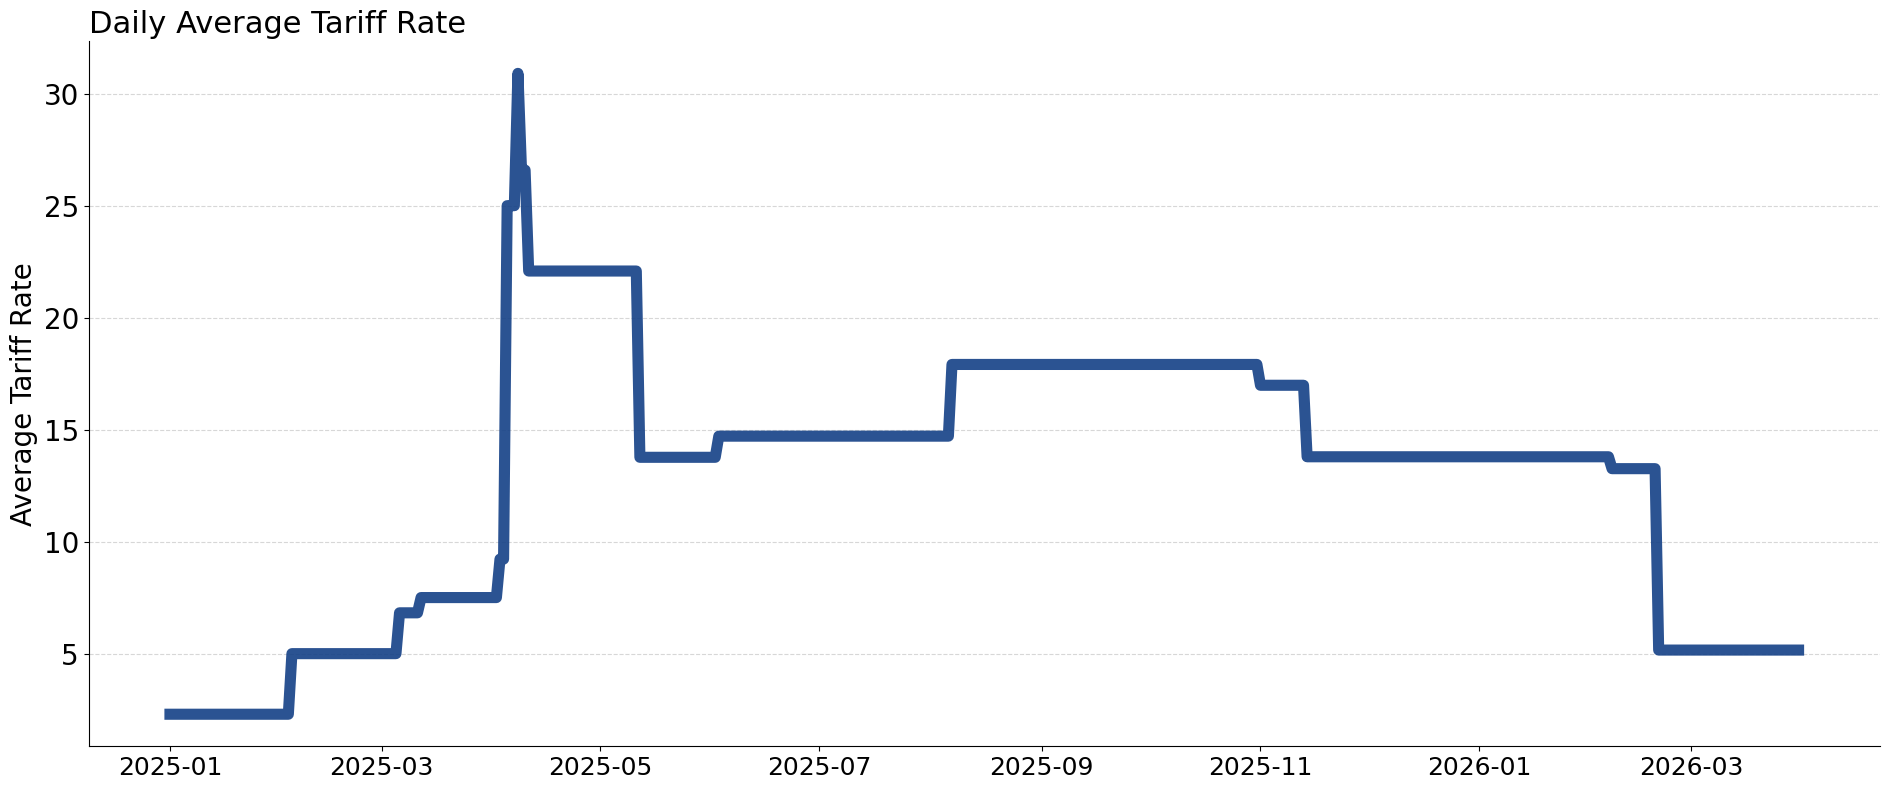

In [32]:
# Forward-fill to daily series
weighted_avg_tariff = weighted_avg_tariff.set_index('date')
full_range = pd.date_range(weighted_avg_tariff.index.min(), '2026-03-31', freq='D')
weighted_avg_tariff_filled = (
    weighted_avg_tariff.reindex(full_range).ffill().reset_index()
    .rename(columns={'index': 'date'})
)

fig, ax = plt.subplots(figsize=(19, 8))
mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot(
    weighted_avg_tariff_filled['date'],
    weighted_avg_tariff_filled['import_weighted_avg_tariff'],
    alpha=0.90, color=mike_blue, linewidth=8, linestyle="-",
)

ax.set_ylabel('Average Tariff Rate', fontsize=20)
ax.set_title("Daily Average Tariff Rate", fontsize=22, loc="left")
ax.yaxis.grid(alpha=0.5, linestyle="--")
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.tight_layout()
plt.show()

In [33]:
tariffs_by_date.to_csv("country-by-time.csv")
weighted_avg_tariff_filled.to_csv("daily-tariff-latest-data.csv")

In [34]:
tariffs_by_date[tariffs_by_date["country_name"] == "CHINA"]

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-02-04,CHINA,20.000000,4.294258e+11,10.865955
2025-03-06,CHINA,20.000000,4.294258e+11,10.865955
2025-03-12,CHINA,20.293655,4.294258e+11,10.865955
2025-04-03,CHINA,20.640687,4.294258e+11,10.865955
2025-04-05,CHINA,50.284015,4.294258e+11,10.865955
2025-04-08,CHINA,93.877143,4.294258e+11,10.865955
2025-04-09,CHINA,112.186257,4.294258e+11,10.865955
2025-04-11,CHINA,87.953520,4.294258e+11,10.865955
2025-05-12,CHINA,26.866274,4.294258e+11,10.865955


In [35]:
tariffs_by_date[tariffs_by_date["country_name"] == "SWITZERLAND"]

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-02-04,SWITZERLAND,0.000000,6.091946e+10,0.596261
2025-03-06,SWITZERLAND,0.000000,6.091946e+10,0.596261
2025-03-12,SWITZERLAND,0.287789,6.091946e+10,0.596261
2025-04-03,SWITZERLAND,0.446413,6.091946e+10,0.596261
2025-04-05,SWITZERLAND,31.875004,6.091946e+10,0.596261
2025-04-08,SWITZERLAND,31.875004,6.091946e+10,0.596261
2025-04-09,SWITZERLAND,10.267848,6.091946e+10,0.596261
2025-04-11,SWITZERLAND,10.138058,6.091946e+10,0.596261
2025-05-12,SWITZERLAND,10.138058,6.091946e+10,0.596261


In [36]:
weighted_avg_tariff_filled.tail()

,date,import_weighted_avg_tariff
450,2026-03-27,5.166234
451,2026-03-28,5.166234
452,2026-03-29,5.166234
453,2026-03-30,5.166234
454,2026-03-31,5.166234
